# Cleaning - missing and duplicate data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Generate some data - specifically a t-shirt order, use the names module to generate random names associated with each order
Order with 300 tshirts, 100 small, 100 medium and 100 large with a bunch missing of missing sizes<br>
have a name, a t-shirt size, and a weight(in pounds)<br>
Use the <a href="https://pypi.org/project/names/https://pypi.org/project/names/">names </a> module to generate random names

In [2]:
#to generate people names
# !pip install names
import names

In [3]:
# average small person weighs 100lbs
# average medium weighs 140 lbs
# average large weighs 180 lbs

#generate a bunch of t-shirts with the following mean,std,numbershirts
x = np.random.normal(100, 15, 100)
x = np.concatenate((x, np.random.normal(140, 20, 100)))
x = np.concatenate((x, np.random.normal(180, 30, 100)))

size=np.empty(300, dtype=object)
size[:99] = 'small'
size[99:199] = 'med'
size[199:300] = 'large'

d = {'weight': x, 't_shirt_size': size}
df = pd.DataFrame(data=d)
df['name'] = "Unknown"
df.name = df.name.map(lambda x: names.get_full_name())

df

,weight,t_shirt_size,name
0,85.424600,small,Mildred Hewitt
1,87.409311,small,David Maynard
2,101.388085,small,Francis Grigsby
3,91.877592,small,John Covington
4,115.487003,small,Ruth Ross
...,...,...,...
295,229.363421,large,Rebecca Taylor
296,194.244850,large,Madeline William
297,165.401549,large,Carol Hollingsworth
298,184.040038,large,Frank Applebaum


### Make some duplicates

In [4]:
# make some duplicates just to show how to handle duplicates (delete them)
#lets find the oldest male and female
def fun1(df,numb=5):
    #generates numb rows from df
    return (df.iloc[0:numb,:])


#generates numb rows from each group to be used as duplicates
df_dups=df.groupby('t_shirt_size').apply(fun1, numb=5)
df_dups

weight t_shirt_size                 name
t_shirt_size                                                  
large        199  153.672557        large       Margaret Mckay
             200  225.273727        large     Hattie Bradfield
             201  202.605937        large        Terry Calcote
             202  173.229739        large    Margarita Clanton
             203  220.477750        large        David Edmonds
med          99    77.894733          med            Dale Cook
             100  112.951554          med        Myrna Houston
             101  167.705564          med        Erin Thompson
             102  168.277361          med       Benjamin Haley
             103  128.629721          med  Christine Baltodano
small        0     85.424600        small       Mildred Hewitt
             1     87.409311        small        David Maynard
             2    101.388085        small      Francis Grigsby
             3     91.877592        small       John Covington
             4    115.487003        small            Ruth Ross

### Append to original dataframe

In [5]:
df=df.append(df_dups, ignore_index=True)
len(df)

315

In [17]:
df.name.duplicated().sum()

15

In [20]:
#show all duplicates
df[df.name.duplicated(keep=False)]

,weight,t_shirt_size,name,t_shirt_size_orig
0,85.424600,small,Mildred Hewitt,small
1,87.409311,small,David Maynard,small
2,101.388085,small,Francis Grigsby,small
3,91.877592,NaN,John Covington,small
4,115.487003,small,Ruth Ross,small
99,77.894733,NaN,Dale Cook,med
100,112.951554,med,Myrna Houston,med
101,167.705564,med,Erin Thompson,med
102,168.277361,NaN,Benjamin Haley,med
103,128.629721,med,Christine Baltodano,med


### randomly select 20% of rows for t_shirt_size ommision

In [6]:
#first save orig size for later comparison
df['t_shirt_size_orig'] = df['t_shirt_size']

In [7]:
import random
res = random.sample(range(0, len(df)), int(0.2 * len(df)))
print(f'Number of rows to have "t_shirt_size" set to np.Nan is {len(res)}' )
for loc in res:
    df.loc[loc,'t_shirt_size'] = np.NaN

Number of rows to have "t_shirt_size" set to np.Nan is 63


In [8]:
#how many are null?
df.t_shirt_size.isna().sum()

63

### Lets take a look at the distribution


#### kind ='hist', hist will bin the number of weights and display them, hue will determine which color group they belong to

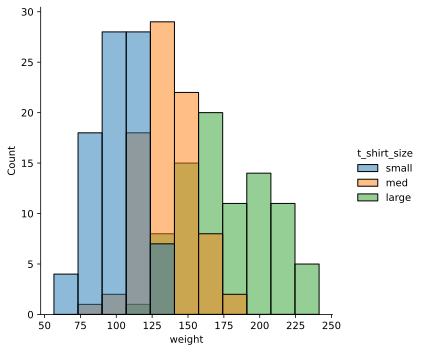

In [9]:
sns.displot(data=df, x="weight",  hue="t_shirt_size", kind='hist', fill=True);

#### kind ='kde', kde is a kernel density estimater, essentially calculates a gaussian distribution around all the points, and adds these distributions to get the smooth curves you see.  I'm showing it because its easier to see the distributions

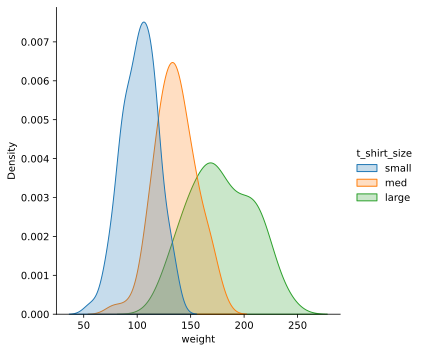

In [10]:
sns.displot(data=df, x="weight",  hue="t_shirt_size", kind='kde', fill=True);

## What to do about duplicates?  Delete them!

### Find them first

In [21]:
df.duplicated(keep=False).sum()

18

### Visually Verify 

In [22]:
df[df.duplicated(keep=False)].sort_values(by='name')

,weight,t_shirt_size,name,t_shirt_size_orig
103,128.629721,med,Christine Baltodano,med
309,128.629721,med,Christine Baltodano,med
1,87.409311,small,David Maynard,small
311,87.409311,small,David Maynard,small
101,167.705564,med,Erin Thompson,med
307,167.705564,med,Erin Thompson,med
2,101.388085,small,Francis Grigsby,small
312,101.388085,small,Francis Grigsby,small
202,173.229739,large,Margarita Clanton,large
303,173.229739,large,Margarita Clanton,large


### Looks good lets dump them

In [25]:
df.drop_duplicates(inplace=True)

## What if one of the duplicated rows is missing the t-shirt size?  Then duplicated() will not find it.  Maybe we should check for duplicates in the 'name' column instead

In [26]:
df.name.duplicated(keep=False).sum()

12

### Verify that they are duplicates first

In [30]:
df[df.name.duplicated(keep=False)].sort_values(by='name')

,weight,t_shirt_size,name,t_shirt_size_orig


### We want to delete the one that has a np.nan for t_shirt_size.

In [28]:
#code to get the condition right
# ((df.name.duplicated()) & (df.t_shirt_size.isna())).sum()
# df.t_shirt_size.isna().sum()
# (df.name.duplicated()) & (df.t_shirt_size.isna())
# df[df.name.duplicated() & (df.t_shirt_size.isna())].index

In [29]:
df.drop( df[df.name.duplicated(keep=False) & (df.t_shirt_size.isna())].index, inplace=True)

## Duplicates are gone, now how to impute the missing fields

### One way is to use SimpleImputer and assign the median value to all the missing values


In [31]:
df_med=df.copy()

In [32]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  #works with strings
imp = imp.fit(df_med[['t_shirt_size']])   #here is where it determines what the most frequent is
df_med['impute_t_shirt_size']=imp.transform(df_med[['t_shirt_size']])  #here is where the transform is applied to create a new column 

In [33]:
# how many match
def printstats(df):
    tmp = df[(df['t_shirt_size'].isna())]
    numb=len(tmp)
    numbmatches=(tmp['t_shirt_size_orig']==tmp['impute_t_shirt_size']).sum()
    print(f'Correctly imputed {numbmatches} out of {numb} missing values')
printstats(df_med)

Correctly imputed 18 out of 57 missing values


In [34]:
# df_med[df_med['t_shirt_size'].isna()]

### Another way is to find the mean weight for each t-shirt size, and then assign missing value t-shirt size based on weight<br>
For each NaN assign t-shirt size to closest mean

#### First calculate average weight for each t-shirt size

In [37]:
df_better=df.copy()

In [38]:
avgs = df_better.groupby('t_shirt_size').mean()
avgs.weight

t_shirt_size
large    178.266428
med      135.811769
small    102.643472
Name: weight, dtype: float64

In [39]:
#how many in each group
df_better.groupby('t_shirt_size').count()

,weight,name,t_shirt_size_orig
t_shirt_size,,,
large,83,83,83
med,79,79,79
small,81,81,81


In [40]:
#map works on a column apply works on a row, which means we have access tothe entire row

def func(row):
    if row.t_shirt_size is np.NaN:
        #get a list of differences between this weight and average weights
        lst_vals = [abs(row.weight-val) for val in avgs.weight]

        #get the index of the minimum value
        min_val = min(lst_vals)
        min_index=lst_vals.index(min_val)

        #return t_shirt_size corresponding to this index
        return avgs.index[min_index]
    #its not missing, return what's there
    return row.t_shirt_size
df_better['impute_t_shirt_size'] = df.apply(func, axis=1)

In [41]:
printstats(df_better)

Correctly imputed 44 out of 57 missing values


In [73]:
# df_better[df_better['t_shirt_size'].isna()]

# Slide for the lecture

In [78]:
def func(df, numb=5):
    return (df.iloc[0:numb,:])
    
df.groupby('t_shirt_size', dropna=False).apply(func,numb=3)

weight t_shirt_size               name t_shirt_size_orig
t_shirt_size                                                                  
large        199  138.423257        large      Shemeka Tweed             large
             201  179.943743        large       Curtis Perry             large
             202  192.245354        large    Jean Vanblarcom             large
med          99   110.433988          med      Marion Murphy               med
             100  172.863897          med     Ronald Edwards               med
             103  143.853752          med  Kathleen Ringrose               med
small        0    104.820189        small   Deborah Bradshaw             small
             1     78.662745        small      Betty Shannon             small
             2     76.240932        small          Mai Audet             small
NaN          5    112.973731          NaN       Pearl Miller             small
             19    92.639737          NaN      Yvonne Arroyo             small
             25    98.201594          NaN         James Dana             small

In [76]:
df.t_shirt_size.isna().sum()

62